In [1]:
import torch
from torch import nn

In [2]:
print(torch.__version__)

1.13.1+cu116


In [3]:
# Setup device-agnostic code
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

# Download custom data

In [4]:
import requests
import zipfile
from pathlib import Path

In [5]:
# Setup path to a data folder
data_path = Path('data/')
image_path = data_path/'pizza_steak_sushi'

# If the image folder doesn't exist, download it and prepare it
if image_path.is_dir():
  print(f'{image_path} directory already exists... skipping download')
else:
  print(f'{image_path} does not exist, create one...')
  image_path.mkdir(parents=True, exist_ok=True)

# Download data
with open(data_path/'pizza_steak_sushi.zip', 'wb') as f:
  request = requests.get('https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip')
  print('Downloading data...')
  f.write(request.content)

# Unzip data
with zipfile.ZipFile(data_path/'pizza_steak_sushi.zip', 'r') as zip_ref:
  print('Unzipping data...')
  zip_ref.extractall(image_path)

data/pizza_steak_sushi does not exist, create one...
Unzipping data...


# Become one with the data

## Explore the data format

In [6]:
import os

In [7]:
def walk_through_dir(dir_path):
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f'There are {len(dirnames)} directories and {len(filenames)} images in {dirpath}')

In [8]:
walk_through_dir(image_path)

There are 2 directories and 0 images in data/pizza_steak_sushi
There are 3 directories and 0 images in data/pizza_steak_sushi/test
There are 0 directories and 19 images in data/pizza_steak_sushi/test/steak
There are 0 directories and 31 images in data/pizza_steak_sushi/test/sushi
There are 0 directories and 25 images in data/pizza_steak_sushi/test/pizza
There are 3 directories and 0 images in data/pizza_steak_sushi/train
There are 0 directories and 75 images in data/pizza_steak_sushi/train/steak
There are 0 directories and 72 images in data/pizza_steak_sushi/train/sushi
There are 0 directories and 78 images in data/pizza_steak_sushi/train/pizza


In [9]:
# Setup train and test paths
train_dir = image_path / 'train'
test_dir = image_path / 'test'

train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

## Visualize a random image

In [10]:
import random
from PIL import Image

Random image path: data/pizza_steak_sushi/test/pizza/2218680.jpg
Image class: pizza
Image height: 512
Image width: 512


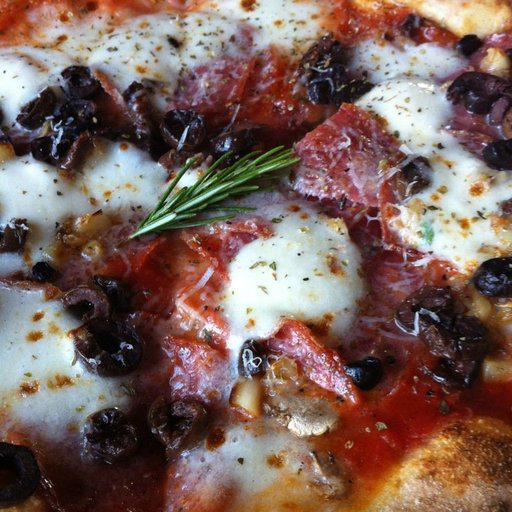

In [11]:
# Set seed
random.seed(42)

# Get all image paths
image_path_list = list(image_path.glob('*/*/*.jpg'))

# Pick a random image path
random_image_path = random.choice(image_path_list)

# Get image class from path name
image_class = random_image_path.parent.stem

# Open image
img = Image.open(random_image_path)

# Print matadata
print(f'Random image path: {random_image_path}')
print(f'Image class: {image_class}')
print(f'Image height: {img.height}')
print(f'Image width: {img.width}')
img

## Visualize a random image with Matplotlib

In [12]:
import numpy as np
import matplotlib.pyplot as plt

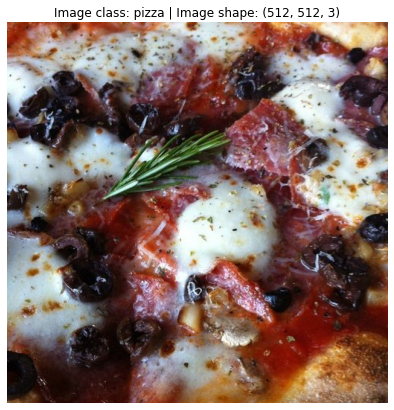

In [13]:
# Turn the image into array
img_as_array = np.asarray(img)

# Plot the image with matplotlib
plt.figure(figsize=(10, 7))
plt.imshow(img_as_array)
plt.title(f'Image class: {image_class} | Image shape: {img_as_array.shape}')
plt.axis(False);

# Transform data

## Turn images into tensors and augmentation

In [14]:
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms

In [15]:
# Write a transform for image
data_transform = transforms.Compose([
    # Resize our image
    transforms.Resize(size=(64, 64)),
    # Flip the images randomly
    transforms.RandomHorizontalFlip(p=0.5),
    # Turn the image into tensor
    transforms.ToTensor()
])

In [16]:
data_transform(img), data_transform(img).shape

(tensor([[[0.6078, 0.7412, 0.8510,  ..., 0.5412, 0.5843, 0.6549],
          [0.7961, 0.8980, 0.9137,  ..., 0.5569, 0.5843, 0.6235],
          [0.8000, 0.9137, 0.9333,  ..., 0.6078, 0.5608, 0.6039],
          ...,
          [0.4706, 0.4902, 0.5373,  ..., 0.0588, 0.0745, 0.0863],
          [0.3686, 0.3804, 0.4549,  ..., 0.1137, 0.0941, 0.0902],
          [0.2431, 0.2902, 0.4039,  ..., 0.3020, 0.3098, 0.2667]],
 
         [[0.3843, 0.4902, 0.6431,  ..., 0.1569, 0.2235, 0.2941],
          [0.6118, 0.7412, 0.7765,  ..., 0.1608, 0.1765, 0.2235],
          [0.5961, 0.8078, 0.8627,  ..., 0.2118, 0.1333, 0.1569],
          ...,
          [0.3490, 0.3686, 0.3922,  ..., 0.0471, 0.0588, 0.0667],
          [0.2588, 0.2706, 0.3333,  ..., 0.0706, 0.0667, 0.0667],
          [0.1529, 0.1961, 0.2902,  ..., 0.1804, 0.1961, 0.1765]],
 
         [[0.2235, 0.2745, 0.3922,  ..., 0.0392, 0.1059, 0.1725],
          [0.3843, 0.5059, 0.5412,  ..., 0.0549, 0.0627, 0.0980],
          [0.4078, 0.6353, 0.6784,  ...,

## Various transformations at once

In [17]:
train_various_transform = transforms.Compose([
    transforms.Resize(size=(224, 224)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31),
    transforms.ToTensor()
])

test_various_transform = transforms.Compose([
    transforms.Resize(size=(224, 224)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31),
    transforms.ToTensor()
])

## Visualize the transformed images

In [18]:
def plot_transformed_image(image_path_list, transform, n=3, seed=None):
  if seed:
    random.seed(seed)

  random_image_paths = random.sample(image_path_list, k=n)
  for image_path in random_image_paths:
    with Image.open(image_path) as f:
      fig, ax = plt.subplots(nrows=1, ncols=2)
      ax[0].imshow(f)
      ax[0].set_title(f'Original\nSize: {f.size}')
      ax[0].axis(False)

      # Transform and plot target image
      transformed_image = transform(f).permute(1,2,0)
      ax[1].imshow(transformed_image)
      ax[1].set_title(f'Transformed\nShape: {transformed_image.shape}')
      ax[1].axis(False)

      fig.suptitle(f'Class: {image_path.parent.stem}', fontsize=16)

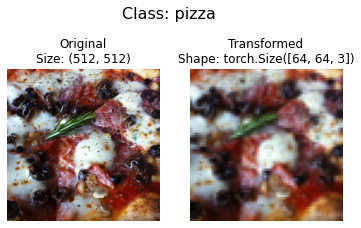

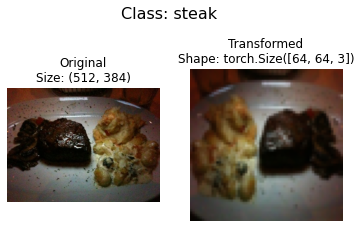

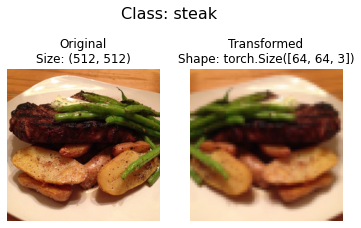

In [19]:
plot_transformed_image(image_path_list, data_transform, n=3, seed=42)

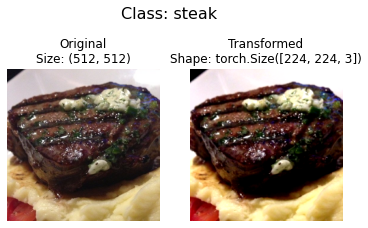

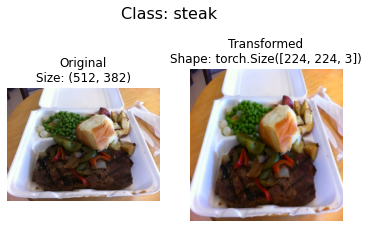

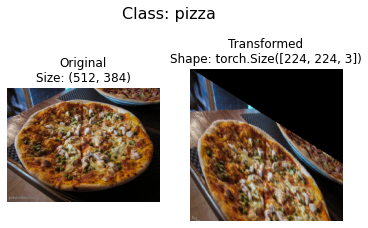

In [20]:
plot_transformed_image(image_path_list, train_various_transform, n=3, seed=None)

# Prepare into torch datasets

## Load all images into tensors with pre-built `ImageFolder`

In [21]:
# Use ImageFolfer to create datasets
train_data = datasets.ImageFolder(train_dir,
                                  data_transform)

test_data = datasets.ImageFolder(test_dir,
                                 data_transform)

In [22]:
train_data, test_data

(Dataset ImageFolder
     Number of datapoints: 225
     Root location: data/pizza_steak_sushi/train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=None)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ), Dataset ImageFolder
     Number of datapoints: 75
     Root location: data/pizza_steak_sushi/test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=None)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ))

In [23]:
# Get class names as list
class_names = train_data.classes
class_names

['pizza', 'steak', 'sushi']

In [24]:
# Get class names as dict
class_dict = train_data.class_to_idx
class_dict

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [25]:
# Check the length of our dataset
len(train_data), len(test_data)

(225, 75)

In [26]:
train_data[0]

(tensor([[[0.1176, 0.1216, 0.1255,  ..., 0.0980, 0.1020, 0.1137],
          [0.1294, 0.1294, 0.1294,  ..., 0.0980, 0.0980, 0.1059],
          [0.1333, 0.1333, 0.1333,  ..., 0.0941, 0.0980, 0.1020],
          ...,
          [0.1686, 0.1647, 0.1686,  ..., 0.1255, 0.1098, 0.1098],
          [0.1686, 0.1647, 0.1686,  ..., 0.1098, 0.0941, 0.0863],
          [0.1647, 0.1647, 0.1686,  ..., 0.0980, 0.0863, 0.0863]],
 
         [[0.0588, 0.0588, 0.0588,  ..., 0.0745, 0.0706, 0.0745],
          [0.0627, 0.0627, 0.0627,  ..., 0.0745, 0.0706, 0.0706],
          [0.0706, 0.0706, 0.0706,  ..., 0.0745, 0.0745, 0.0706],
          ...,
          [0.2392, 0.2392, 0.2510,  ..., 0.1373, 0.1333, 0.1255],
          [0.2314, 0.2392, 0.2510,  ..., 0.1255, 0.1176, 0.1098],
          [0.2275, 0.2353, 0.2431,  ..., 0.1137, 0.1059, 0.1020]],
 
         [[0.0196, 0.0196, 0.0196,  ..., 0.0902, 0.0902, 0.0941],
          [0.0196, 0.0157, 0.0196,  ..., 0.0902, 0.0863, 0.0902],
          [0.0196, 0.0157, 0.0157,  ...,

In [27]:
# Index on the train_data dataset to get a single image and label
img, label = train_data[0][0], train_data[0][1]
print(f'Image tensor:\n{img}')
print(f'Image shape: {img.shape}')
print(f'Image datatype: {img.dtype}')
print(f'Image label: {label}')
print(f'Label datatype: {type(label)}')

Image tensor:
tensor([[[0.1176, 0.1216, 0.1255,  ..., 0.0980, 0.1020, 0.1137],
         [0.1294, 0.1294, 0.1294,  ..., 0.0980, 0.0980, 0.1059],
         [0.1333, 0.1333, 0.1333,  ..., 0.0941, 0.0980, 0.1020],
         ...,
         [0.1686, 0.1647, 0.1686,  ..., 0.1255, 0.1098, 0.1098],
         [0.1686, 0.1647, 0.1686,  ..., 0.1098, 0.0941, 0.0863],
         [0.1647, 0.1647, 0.1686,  ..., 0.0980, 0.0863, 0.0863]],

        [[0.0588, 0.0588, 0.0588,  ..., 0.0745, 0.0706, 0.0745],
         [0.0627, 0.0627, 0.0627,  ..., 0.0745, 0.0706, 0.0706],
         [0.0706, 0.0706, 0.0706,  ..., 0.0745, 0.0745, 0.0706],
         ...,
         [0.2392, 0.2392, 0.2510,  ..., 0.1373, 0.1333, 0.1255],
         [0.2314, 0.2392, 0.2510,  ..., 0.1255, 0.1176, 0.1098],
         [0.2275, 0.2353, 0.2431,  ..., 0.1137, 0.1059, 0.1020]],

        [[0.0196, 0.0196, 0.0196,  ..., 0.0902, 0.0902, 0.0941],
         [0.0196, 0.0157, 0.0196,  ..., 0.0902, 0.0863, 0.0902],
         [0.0196, 0.0157, 0.0157,  ..., 0.09

Original shape: torch.Size([3, 64, 64])
Image permute shape: torch.Size([64, 64, 3])


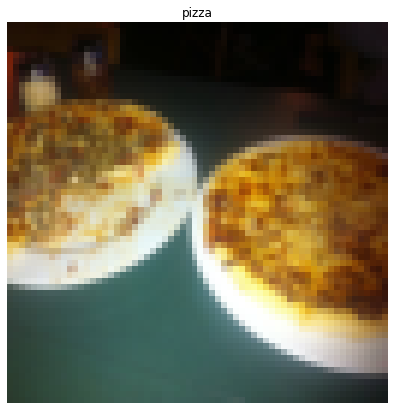

In [28]:
# Rearrange the dimension order
img_permute = img.permute(1, 2, 0)

# Print out different shapes
print(f'Original shape: {img.shape}')
print(f'Image permute shape: {img_permute.shape}')

# Plot the image
plt.figure(figsize=(10, 7))
plt.imshow(img_permute)
plt.title(class_names[label])
plt.axis(False)
plt.show()

## Turn datasets into `DataLoader`s

In [29]:
# Turn train and test datasets into DataLoaders
BATCH_SIZE = 32

train_dataloader = DataLoader(train_data,
                              batch_size=BATCH_SIZE,
                              num_workers=os.cpu_count(),
                              shuffle=True)

test_dataloader = DataLoader(test_data,
                             batch_size=BATCH_SIZE,
                             num_workers=os.cpu_count(),
                             shuffle=False)

In [30]:
train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7f38a1665bb0>,
 <torch.utils.data.dataloader.DataLoader at 0x7f38a16654c0>)

In [31]:
len(train_dataloader), len(test_dataloader)

(8, 3)

In [32]:
# Check out the shape of a sample
img, label = next(iter(train_dataloader))

print(f'Image shape: {img.shape}')
print(f'Label shape: {label.shape}')

Image shape: torch.Size([32, 3, 64, 64])
Label shape: torch.Size([32])


# Build a custom dataloader class

## Subclass `torch.utils.data.Dataset`

In [33]:
from typing import Tuple, Dict, List

In [34]:
# Instance of torchvision.datasets.ImageFolder()
train_data.classes, train_data.class_to_idx

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

In [35]:
train_dir

PosixPath('data/pizza_steak_sushi/train')

In [36]:
image_path

PosixPath('data/pizza_steak_sushi')

In [37]:
# Setup path for target directory
target_directory = train_dir
print(f'Target dir: {target_directory}')

# Get the class names from the directory
class_names_found = sorted(entry.name for entry in list(os.scandir(target_directory)))
class_names_found

Target dir: data/pizza_steak_sushi/train


['pizza', 'steak', 'sushi']

In [38]:
list(os.scandir(target_directory))

[<DirEntry 'steak'>, <DirEntry 'sushi'>, <DirEntry 'pizza'>]

In [39]:
def find_classes(directory: str) -> Tuple[List[str], Dict[str, int]]:
  classes = sorted(entry.name for entry in os.scandir(directory) if entry.is_dir())
  if not classes:
    raise FileNotFoundError(f"Couldn't fine any classes in {directory}... Please check file structure.")

  class_to_idx = {class_name: i for i, class_name in enumerate(classes)}
  return classes, class_to_idx

In [40]:
find_classes(target_directory)

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

In [41]:
# Subclass torch.utils.data.Dataset
class ImageFolderCustom(Dataset):
  def __init__(self,
               target_dir: str,
               transform=None):
    # Create class attributes
    self.paths = list(Path(target_directory).glob('*/*.jpg'))
    # Setup transform
    self.transform = transform
    # Create classes and class_to_idx attributes
    self.classes, self.class_to_idx = find_classes(target_directory)

  # Create a function to load images
  def load_image(self, index: int) -> Image.Image:
    image_path = self.paths[index]
    return Image.open(image_path)

  # Overwrite __len()__
  def __len__(self) -> int:
    """
    Return the total number of samples.
    """
    return len(self.paths)

  # Overwrite __getitem()__ to return a particular sample
  def __getitem__(self, index: int) -> Tuple[torch.Tensor, int]:
    """
    Returns one sample of data, data and label (X, y).
    """
    img = self.load_image(index)
    class_name = self.paths[index].parent.name
    class_idx = self.class_to_idx[class_name]
    
    # Transform if necessary
    if self.transform:
      return self.transform(img), class_idx
    else:
      return img, class_idx

In [42]:
from torchvision.transforms.transforms import ToTensor
# Create a transform
train_transforms = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
])

test_transforms = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.ToTensor()
])

In [43]:
# Test our ImageFolferCustom
train_data_custom = ImageFolderCustom(train_dir, train_transforms)
test_data_custom = ImageFolderCustom(test_dir, test_transforms)

In [44]:
train_data_custom, test_data_custom

(<__main__.ImageFolderCustom at 0x7f38a177f280>,
 <__main__.ImageFolderCustom at 0x7f38a177f5e0>)

In [45]:
len(train_data), len(train_data_custom)

(225, 225)

In [46]:
train_data_custom.classes

['pizza', 'steak', 'sushi']

In [47]:
train_data_custom.class_to_idx

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [48]:
train_data_custom.paths

[PosixPath('data/pizza_steak_sushi/train/steak/1761285.jpg'),
 PosixPath('data/pizza_steak_sushi/train/steak/1839481.jpg'),
 PosixPath('data/pizza_steak_sushi/train/steak/2254705.jpg'),
 PosixPath('data/pizza_steak_sushi/train/steak/1615395.jpg'),
 PosixPath('data/pizza_steak_sushi/train/steak/1598345.jpg'),
 PosixPath('data/pizza_steak_sushi/train/steak/560503.jpg'),
 PosixPath('data/pizza_steak_sushi/train/steak/1736968.jpg'),
 PosixPath('data/pizza_steak_sushi/train/steak/2878151.jpg'),
 PosixPath('data/pizza_steak_sushi/train/steak/355715.jpg'),
 PosixPath('data/pizza_steak_sushi/train/steak/214320.jpg'),
 PosixPath('data/pizza_steak_sushi/train/steak/97656.jpg'),
 PosixPath('data/pizza_steak_sushi/train/steak/2603058.jpg'),
 PosixPath('data/pizza_steak_sushi/train/steak/2614649.jpg'),
 PosixPath('data/pizza_steak_sushi/train/steak/1624747.jpg'),
 PosixPath('data/pizza_steak_sushi/train/steak/1647351.jpg'),
 PosixPath('data/pizza_steak_sushi/train/steak/2163079.jpg'),
 PosixPath('d

In [49]:
# Check for quality between original ImageFolder and custom ImageFolderCustom
print(train_data_custom.classes==train_data.classes)
print(test_data_custom.classes==test_data.classes)

True
True


## Visualize random images

In [50]:
def display_random_images(dataset: torch.utils.data.Dataset,
                          classes: List[str] = None,
                          n: int = 10,
                          display_shape: bool = True,
                          seed: int = None):
  # Adjust display if n is too high
  if n > 10:
    n = 10
    display_shape = False
    print(f"For display purpose, n shouldn't be larger than 10, setting to 10 and removing shape display")
  
  # Set seed
  if seed:
    random.seed(seed)

  # Get random sample indexes
  random_sample_idx = random.sample(range(len(dataset)), k=n)

  # Setup plot
  plt.figure(figsize=(16, 8))

  # Loop throught random indexes and plot them
  for i, target_idx in enumerate(random_sample_idx):
    target_image, target_label = dataset[target_idx][0], dataset[target_idx][1]

    # Adjust tensor dimensions for plotting
    target_image_adjust = target_image.permute(1,2,0)

    # Plot adjusted sample
    plt.subplot(1, n, i+1)
    plt.imshow(target_image_adjust)
    plt.axis(False)
    if classes:
      title = f"Class: {classes[target_label]}"
      if display_shape:
        title = title + f"\nshape: {target_image_adjust.shape}"
    plt.title(title)

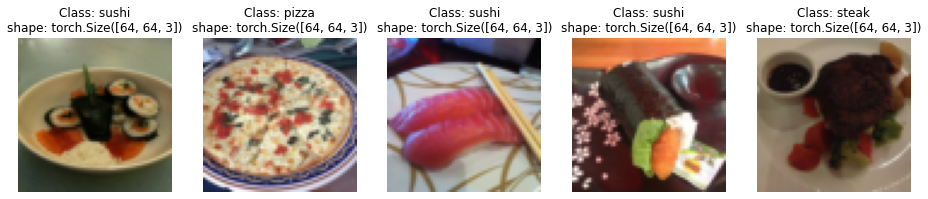

In [51]:
display_random_images(train_data,
                      class_names,
                      5)

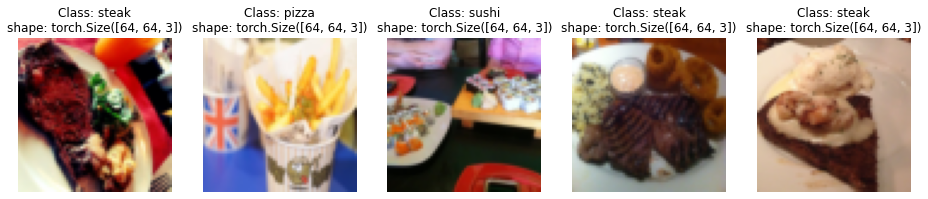

In [52]:
display_random_images(train_data_custom,
                      class_names,
                      5)

## Turn custom dataset into `DataLoader`s

In [53]:
BATCH_SIZE = 32

train_dataloader_custom = DataLoader(dataset=train_data_custom,
                                     batch_size=BATCH_SIZE,
                                     shuffle=True,
                                     num_workers=os.cpu_count())

test_dataloader_custom = DataLoader(dataset=test_data_custom,
                                    batch_size=BATCH_SIZE,
                                    num_workers=os.cpu_count())

In [54]:
train_dataloader_custom, test_dataloader_custom

(<torch.utils.data.dataloader.DataLoader at 0x7f38a188c5b0>,
 <torch.utils.data.dataloader.DataLoader at 0x7f38a188cf70>)

In [55]:
# Get image and label from custom dataloader
img_custom, label_custom = next(iter(train_dataloader_custom))

# Print out shape
print(f"Shape of image: {img_custom.shape}")
print(f"Shape if label: {label_custom.shape}")

Shape of image: torch.Size([32, 3, 64, 64])
Shape if label: torch.Size([32])


# Build baseline model 0

## Load and transform data

In [56]:
from torchvision.datasets.imagenet import ImageFolder
# Create simple transform
simple_transform = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.ToTensor()
])

# Load and transform data
train_data_simple = ImageFolder(train_dir, simple_transform)
test_data_simple = ImageFolder(test_dir, simple_transform)

# Turn datasets into dataloaders
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()
print(f"Creating DataLoader's with batch size {BATCH_SIZE} and {NUM_WORKERS} workers.")

train_dataloader_simple = DataLoader(train_data_simple,
                                     BATCH_SIZE,
                                     shuffle = True,
                                     num_workers=NUM_WORKERS)

test_dataloader_simple = DataLoader(test_data_simple,
                                    BATCH_SIZE,
                                    shuffle = False,
                                    num_workers=NUM_WORKERS)

Creating DataLoader's with batch size 32 and 2 workers.


## Replicate Tiny VGG from scratch

In [57]:
class TinyVGG(nn.Module):
  def __init__(self,
               input_shape: int,
               hidden_units: int,
               output_shape: int) -> None:
    super().__init__()
    self.conv_block_1 = nn.Sequential(
        nn.Conv2d(in_channels=input_shape,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2,
                     stride=2),
    )

    self.conv_block_2 = nn.Sequential(
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2,
                     stride=2),
    )

    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=hidden_units * 256,
                  out_features=output_shape)
    )

  def forward(self, x):
    x = self.conv_block_1(x)
    #print(f"conv_block_1 output shape: {x.shape}")
    x = self.conv_block_2(x)
    #print(f"conv_block_2 output shape: {x.shape}")
    x = self.classifier(x)
    #print(f"Final output shape: {x.shape}")
    return x

## Try a forward pass on a single image

In [58]:
test_img, test_label = next(iter(train_dataloader_simple))

In [59]:
test_img.shape, test_label.shape

(torch.Size([32, 3, 64, 64]), torch.Size([32]))

In [60]:
torch.manual_seed(42)
model_0 = TinyVGG(input_shape=3, hidden_units=10, output_shape=len(class_names)).to(device)

In [61]:
model_0

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=2560, out_features=3, bias=True)
  )
)

In [62]:
model_0(test_img.to(device))

tensor([[0.0633, 0.0622, 0.0372],
        [0.0636, 0.0603, 0.0367],
        [0.0605, 0.0602, 0.0393],
        [0.0636, 0.0665, 0.0390],
        [0.0615, 0.0622, 0.0367],
        [0.0606, 0.0606, 0.0360],
        [0.0625, 0.0613, 0.0355],
        [0.0693, 0.0663, 0.0407],
        [0.0697, 0.0657, 0.0412],
        [0.0635, 0.0656, 0.0388],
        [0.0642, 0.0632, 0.0400],
        [0.0673, 0.0616, 0.0381],
        [0.0740, 0.0676, 0.0400],
        [0.0613, 0.0630, 0.0379],
        [0.0630, 0.0637, 0.0382],
        [0.0637, 0.0617, 0.0385],
        [0.0690, 0.0657, 0.0402],
        [0.0657, 0.0651, 0.0391],
        [0.0680, 0.0626, 0.0356],
        [0.0624, 0.0591, 0.0388],
        [0.0637, 0.0589, 0.0352],
        [0.0644, 0.0620, 0.0405],
        [0.0680, 0.0625, 0.0395],
        [0.0553, 0.0553, 0.0362],
        [0.0702, 0.0663, 0.0405],
        [0.0685, 0.0636, 0.0398],
        [0.0642, 0.0632, 0.0378],
        [0.0688, 0.0647, 0.0379],
        [0.0605, 0.0600, 0.0374],
        [0.064

## Get a summary of the model

In [63]:
# Install torchinfo, import if it's available
try:
  import torchinfo
except:
  !pip install torchinfo
  import torchinfo

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [64]:
from torchinfo import summary
summary(model_0, input_size=[1, 3, 64, 64])

Layer (type:depth-idx)                   Output Shape              Param #
TinyVGG                                  [1, 3]                    --
├─Sequential: 1-1                        [1, 10, 32, 32]           --
│    └─Conv2d: 2-1                       [1, 10, 64, 64]           280
│    └─ReLU: 2-2                         [1, 10, 64, 64]           --
│    └─Conv2d: 2-3                       [1, 10, 64, 64]           910
│    └─ReLU: 2-4                         [1, 10, 64, 64]           --
│    └─MaxPool2d: 2-5                    [1, 10, 32, 32]           --
├─Sequential: 1-2                        [1, 10, 16, 16]           --
│    └─Conv2d: 2-6                       [1, 10, 32, 32]           910
│    └─ReLU: 2-7                         [1, 10, 32, 32]           --
│    └─Conv2d: 2-8                       [1, 10, 32, 32]           910
│    └─ReLU: 2-9                         [1, 10, 32, 32]           --
│    └─MaxPool2d: 2-10                   [1, 10, 16, 16]           --
├─Sequentia

# Train and evaluate model

## Create train and test loops

In [65]:
# Create train_step()
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               device=device):
  # Put the model on device
  #model.to(device)

  # Put model in train model
  model.train()

  # Setup train loss and train accuracy values
  train_loss, train_acc = 0, 0

  # Loop through dataloader batches
  for batch, (X, y) in enumerate(dataloader):
    # Send data to device
    X, y = X.to(device), y.to(device)

    # Forward pass
    y_pred = model(X)

    # Calculate the loss
    loss = loss_fn(y_pred, y)
    train_loss += loss.item()
    
    # Optimizer grad
    optimizer.zero_grad()

    # Loss backward
    loss.backward()

    # Optimizer step
    optimizer.step()

    # Calculate accuracy metrics
    y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
    train_acc += ((y_pred_class == y).sum().item() / len(y_pred))

  # Adjust metrics to get average loss and accuracy per batch
  train_loss /= len(dataloader)
  train_acc /= len(dataloader)

  return train_loss, train_acc

In [66]:
# Create test_step()
def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              device=device) -> None:
  # Send model to device
  #model.to(device)

  # Put model in eval mode
  model.eval()
 
  # Set test_loss and test_acc
  test_loss, test_acc = 0, 0

  # Turn inference mode
  with torch.inference_mode():
    # Loop through dataloader
    for batch, (X, y) in enumerate(dataloader):
      # Put data to device
      X, y = X.to(device), y.to(device)

      # Forward pass
      test_pred_scores = model(X)

      # Calculate the loss
      loss = loss_fn(test_pred_scores, y)
      test_loss += loss.item()

      # Calculate accuracy metrics
      test_pred_class = torch.argmax(test_pred_scores, dim=1)
      test_acc += ((test_pred_class == y).sum().item() / len(test_pred_class))

  # Adjust to get average loss and accuracy
  test_loss /= len(dataloader)
  test_acc /= len(dataloader)

  return test_loss, test_acc

## Create train function to evaluate model

In [67]:
def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 5,
          device=device):
  
  # Create empty results dictionary
  results = {"train_loss": [],
             "train_acc": [],
             "test_loss": [],
             "test_acc": []}

  # Loop through training and testing data
  from tqdm.auto import tqdm
  for epoch in tqdm(range(epochs)):
    train_loss, train_acc = train_step(model,
                                       train_dataloader,
                                       loss_fn,
                                       optimizer,
                                       device)
    
    test_loss, test_acc = test_step(model,
                                    test_dataloader,
                                    loss_fn,
                                    device)
    
    # Print out what's happening
    print(f"Epoch: {epoch+1} | Train loss: {train_loss:.4f} | Train accuracy: {train_acc:.2f} | Test loss: {test_loss:.4f} | Test accuracy: {test_acc:.2f}")

    # Updata results dictionay
    results["train_loss"].append(train_loss)
    results['train_acc'].append(train_acc)
    results['test_loss'].append(test_loss)
    results['test_acc'].append(test_acc)

  # Return the final results
  return results

## Train and evaluate

In [68]:
class_names

['pizza', 'steak', 'sushi']

In [69]:
train_data.classes

['pizza', 'steak', 'sushi']

In [70]:
# Set random seed
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set hyperparameters
NUM_EPOCHS = 5

# Recreate an instance of TinyVGG
model_0 = TinyVGG(input_shape=3,
                  hidden_units=10,
                  output_shape=len(class_names)).to(device)

# Setup loss functions and optimizer
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_0.parameters(), lr=0.001)

# Start the timer
from timeit import default_timer as timer
start = timer()

# Train model_0
model_0_results = train(model_0,
                        train_dataloader_simple,
                        test_dataloader_simple,
                        optimizer,
                        loss_fn,
                        NUM_EPOCHS)

# End the timer and print out how long it takes
end = timer()
print(f"Total training data: {end-start:.3f} seconds.")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | Train loss: 1.1078 | Train accuracy: 0.26 | Test loss: 1.1360 | Test accuracy: 0.26
Epoch: 2 | Train loss: 1.0847 | Train accuracy: 0.43 | Test loss: 1.1620 | Test accuracy: 0.20
Epoch: 3 | Train loss: 1.1157 | Train accuracy: 0.29 | Test loss: 1.1697 | Test accuracy: 0.20
Epoch: 4 | Train loss: 1.0956 | Train accuracy: 0.41 | Test loss: 1.1385 | Test accuracy: 0.20
Epoch: 5 | Train loss: 1.0985 | Train accuracy: 0.29 | Test loss: 1.1428 | Test accuracy: 0.20
Total training data: 10.472 seconds.


In [71]:
model_0_results

{'train_loss': [1.1078328788280487,
  1.0847125351428986,
  1.1156976968050003,
  1.0955592691898346,
  1.0985160917043686],
 'train_acc': [0.2578125, 0.42578125, 0.29296875, 0.4140625, 0.29296875],
 'test_loss': [1.1360409259796143,
  1.1620128552118938,
  1.1697043975194295,
  1.1384987831115723,
  1.1427963574727376],
 'test_acc': [0.2604166666666667,
  0.19791666666666666,
  0.19791666666666666,
  0.19791666666666666,
  0.19791666666666666]}

## Plot loss curves

In [74]:
from matplotlib import legend
def plot_loss_curves(results: Dict[str, List[float]]):
  df = pd.DataFrame(results)
  df.plot()

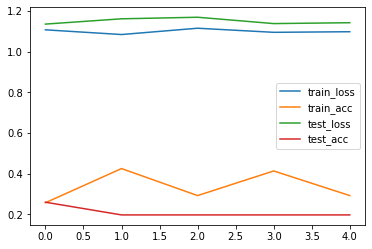

In [75]:
plot_loss_curves(model_0_results)

# model 1 with data augmentation

## Create training augmented dataset and dataloader

In [76]:
# Create training transform with TrivialAugment
train_transform_trivial = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.TrivialAugmentWide(),
    transforms.ToTensor()
])

test_transform_trivial = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.ToTensor()
])

In [77]:
# Create transformed datasets
train_data_augmented = ImageFolder(train_dir,
                                   train_transform_trivial)

test_data_augmented = ImageFolder(test_dir,
                                  test_transform_trivial)

In [78]:
# Turn datasets into dataloaders
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()

torch.manual_seed(42)

train_dataloader_augmented = DataLoader(train_data_augmented,
                                        BATCH_SIZE,
                                        True,
                                        num_workers=NUM_WORKERS)

test_dataloader_augmented = DataLoader(test_data_augmented,
                                       BATCH_SIZE,
                                       False,
                                       num_workers=NUM_WORKERS)

## Construct model_1 from TinyVGG

In [79]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

model_1 = TinyVGG(input_shape=3,
                  hidden_units=10,
                  output_shape=len(class_names)).to(device)

model_1

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=2560, out_features=3, bias=True)
  )
)

## Train and evaluate model_1

In [80]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

NUM_EPOCHS = 5

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_1.parameters(), lr=0.001)

start = timer()

model_1_results = train(model_1,
                        train_dataloader_augmented,
                        test_dataloader_augmented,
                        optimizer,
                        loss_fn,
                        NUM_EPOCHS,
                        device)

end = timer()

print(f'Training time for model_1: {end-start} seconds.')

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | Train loss: 1.1076 | Train accuracy: 0.25 | Test loss: 1.1061 | Test accuracy: 0.26
Epoch: 2 | Train loss: 1.0791 | Train accuracy: 0.43 | Test loss: 1.1387 | Test accuracy: 0.26
Epoch: 3 | Train loss: 1.0812 | Train accuracy: 0.43 | Test loss: 1.1696 | Test accuracy: 0.26
Epoch: 4 | Train loss: 1.1292 | Train accuracy: 0.30 | Test loss: 1.1628 | Test accuracy: 0.26
Epoch: 5 | Train loss: 1.0901 | Train accuracy: 0.43 | Test loss: 1.1486 | Test accuracy: 0.26
Training time for model_1: 9.09821726600012 seconds.


## Plot loss curves

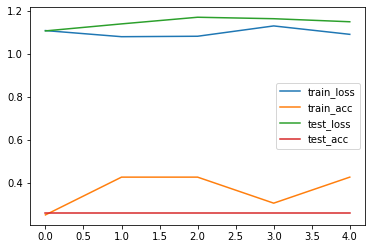

In [81]:
plot_loss_curves(model_1_results)

# Make prediction on custom data

## Download custom image

In [83]:
# Download custom image
custom_image_path = data_path/'04-pizza-dad.jpeg'
if not custom_image_path.is_file():
  with open(custom_image_path, 'wb') as f:
    request = requests.get('https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/04-pizza-dad.jpeg')
    print(f'Downloading {custom_image_path}...')
    f.write(request.content)
else:
  print(f'{custom_image_path} already exists, skipping download...')

## Load in the custom image into tensor form

In [88]:
import torchvision
# Read in custom image
custom_image = torchvision.io.read_image(str(custom_image_path))/255.
custom_image, custom_image.dtype

(tensor([[[0.6039, 0.6784, 0.7098,  ..., 0.0824, 0.0706, 0.0549],
          [0.5725, 0.6471, 0.7098,  ..., 0.0824, 0.0706, 0.0588],
          [0.4863, 0.5725, 0.6745,  ..., 0.0706, 0.0667, 0.0588],
          ...,
          [0.2824, 0.2314, 0.1765,  ..., 0.5961, 0.5882, 0.5804],
          [0.2510, 0.2157, 0.1608,  ..., 0.5882, 0.5765, 0.5647],
          [0.2510, 0.2353, 0.1804,  ..., 0.5843, 0.5725, 0.5608]],
 
         [[0.6706, 0.7451, 0.7569,  ..., 0.0863, 0.0745, 0.0588],
          [0.6392, 0.7137, 0.7569,  ..., 0.0863, 0.0745, 0.0627],
          [0.5529, 0.6392, 0.7216,  ..., 0.0745, 0.0706, 0.0627],
          ...,
          [0.2157, 0.1647, 0.1098,  ..., 0.4196, 0.4078, 0.4039],
          [0.1843, 0.1490, 0.0941,  ..., 0.4235, 0.4078, 0.4000],
          [0.1843, 0.1686, 0.1137,  ..., 0.4196, 0.4078, 0.3961]],
 
         [[0.4667, 0.5412, 0.5765,  ..., 0.0667, 0.0549, 0.0392],
          [0.4353, 0.5098, 0.5686,  ..., 0.0667, 0.0549, 0.0431],
          [0.3412, 0.4353, 0.5333,  ...,

In [89]:
# Create transform pipeline to resize image
custom_image_transform = transforms.Compose([transforms.Resize(size=(64, 64))])

# Transform the custom image
custom_image_transformed = custom_image_transform(custom_image)

# Print out info
print(f'Original shape: {custom_image.shape}')
print(f'Transformed shape: {custom_image_transformed.shape}')

Original shape: torch.Size([3, 4032, 3024])
Transformed shape: torch.Size([3, 64, 64])


## Predict on the custom image

In [90]:
model_1.eval()
with torch.inference_mode():
  custom_image_pred = model_1(custom_image_transformed.unsqueeze(0).to(device))
custom_image_pred

tensor([[ 0.1155,  0.0344, -0.1422]], device='cuda:0')

In [93]:
custom_image_class = class_names[custom_image_pred.argmax(dim=1).item()]
custom_image_class

'pizza'

## Put everything together

In [101]:
def pred_and_plot(model: torch.nn.Module,
                  image_path: str,
                  class_names: List[str] = None,
                  transform=None,
                  device=device):
  # Load in image
  target_image = torchvision.io.read_image(str(image_path)).type(torch.float32)/255.

  # Transform if necessary
  if transform:
    target_image = transform(target_image)

  # Send model to device
  if device:
    model.to(device)

  # Predict on target image
  model.eval()
  with torch.inference_mode():
    target_image = target_image.unsqueeze(0)
    target_image_pred = model(target_image.to(device))
    target_image_prob = torch.softmax(target_image_pred, dim=1)
    index = target_image_prob.argmax(dim=1)
    target_image_class = class_names[index]

  plt.imshow(target_image.squeeze().permute(1,2,0))
  plt.title(f"Prediction: {target_image_class} with probability {target_image_prob.squeeze()[index].item():.4f}")

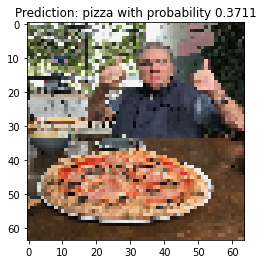

In [102]:
pred_and_plot(model_1,
              custom_image_path,
              class_names,
              custom_image_transform)